In [55]:
# dataframe opertations - pandas
import pandas as pd
# Import numpy for array parsing
import numpy as np
# Import math for rounding numbers when splitting index
from math import floor
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Metrics used for testing model performanc
from sklearn.metrics import mean_absolute_error,mean_squared_error



(77930, 4)
                 timestamp                  name attribute_name  value
0  2021-04-18 05:03:14.376  Philitelaan Videolab       occupied    3.0
1  2021-04-18 05:03:14.379    Philitelaan BLOK61       occupied    1.0
2  2021-04-18 05:04:16.815  Philitelaan Videolab       occupied    3.0
3  2021-04-18 05:04:16.818    Philitelaan BLOK61       occupied    1.0
4  2021-04-23 04:20:38.034  Philitelaan Videolab       occupied    5.0


<AxesSubplot:title={'center':'parking data'}>

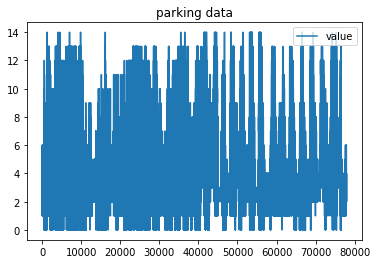

In [56]:
df = pd.read_csv('datapoints.csv')
# finding shape of the dataframe
print(df.shape)
# having a look at the data
print(df.head())
# plotting the original data
df[['value']].plot(title='parking data')

In [57]:
df['date'] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['timestamp', 'date'], axis=1, inplace=True)
df["datetime"] = df.index 

df.sort_index(inplace=True)
mask = df.name.str.contains("BLOK61")
df_blok = df[mask]
df_videolab = df[~mask]

df_videolab = df_videolab.resample(rule='15T', closed='left', label='left').mean().apply(np.ceil)


df_videolab_filtered = df_videolab["value"].to_numpy()

df_videolab = df_videolab.dropna()

#df_videolab = df_videolab[:1000]

df_videolab


,value
date,
2021-04-05 02:00:00,3.0
2021-04-05 02:15:00,3.0
2021-04-05 02:30:00,3.0
2021-04-05 02:45:00,3.0
2021-04-05 03:00:00,3.0
...,...
2021-05-06 15:30:00,8.0
2021-05-06 15:45:00,7.0
2021-05-06 16:00:00,7.0


In [58]:
np.any(df_videolab["value"] <= 0)
df_videolab = df_videolab.dropna()
np.all(np.isfinite(df_videolab["value"]))

True

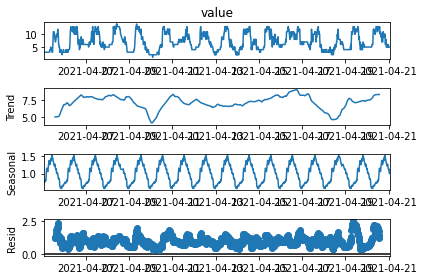

In [59]:
# Period is 4 steps per hour, so daily is 4*24
period = 4*24
decompose_result = seasonal_decompose(df_videolab["value"][:1500] ,model='multiplicative', period=period)
decompose_result.plot();

In [60]:

# Set the value of Alpha and define m (Time Period)
m = period
alpha = 1/(2*m)



C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


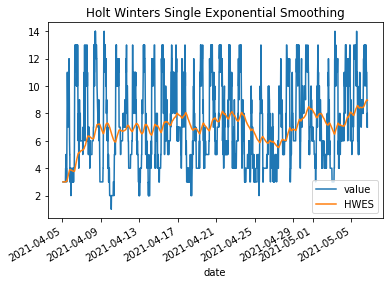

In [61]:
df_videolab['HWES'] = SimpleExpSmoothing(df_videolab['value']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
df_videolab[['value','HWES']].plot(title='Holt Winters Single Exponential Smoothing');

C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


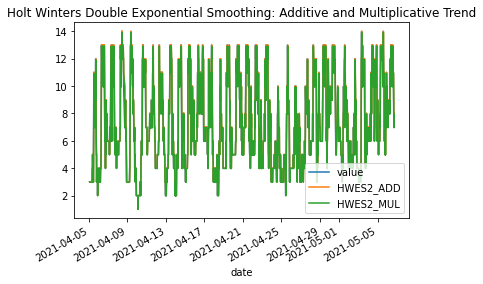

In [62]:
df_videolab['HWES2_ADD'] = ExponentialSmoothing(df_videolab['value'],trend='add').fit().fittedvalues

df_videolab['HWES2_MUL'] = ExponentialSmoothing(df_videolab['value'],trend='mul').fit().fittedvalues

df_videolab[['value','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index h

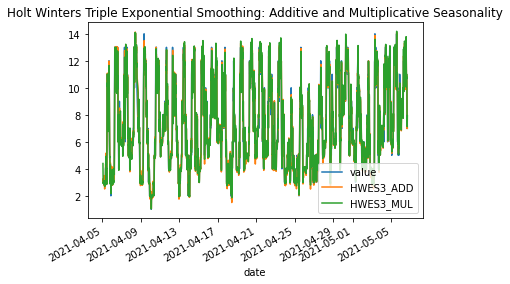

In [63]:
df_videolab['HWES3_ADD'] = ExponentialSmoothing(df_videolab['value'],trend='add',seasonal='add',seasonal_periods=m).fit().fittedvalues
df_videolab['HWES3_MUL'] = ExponentialSmoothing(df_videolab['value'],trend='mul',seasonal='mul',seasonal_periods=m).fit().fittedvalues
df_videolab[['value','HWES3_ADD', 'HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');

In [64]:
split = floor(len(df_videolab) * 0.8)

df_train = df_videolab[:split]
df_test = df_videolab[split:]

C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Niek\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

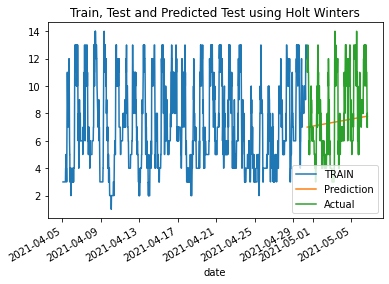

In [65]:


# fitted_model = ExponentialSmoothing(df_train["value"],trend='mul',seasonal='mul',seasonal_periods=m).fit()
#fitted_model = ExponentialSmoothing(df_videolab['value'],trend='add',seasonal='add',seasonal_periods=m/4).fit()
#fitted_model = ExponentialSmoothing(df_videolab['value'],trend='add').fit()
"""HWES2_ADD"""
fitted_model = ExponentialSmoothing(df_videolab['value'],trend='add').fit()
"""HWES3_ADD"""
#fitted_model = ExponentialSmoothing(df_videolab['value'],trend='add',seasonal='add',seasonal_periods=m).fit()
"""HWES3_MUL"""
#fitted_model = ExponentialSmoothing(df_videolab['value'],trend='mul',seasonal='mul',seasonal_periods=m).fit().fittedvalues

test_predictions = fitted_model.forecast(len(df_test))
test_predictions.index = df_test.index



df_train['value'].plot(legend=True,label='TRAIN')
test_predictions.plot(legend=True,label='Prediction')
df_test['value'].plot(legend=True,label='Actual',figsize=(6,4))

plt.title('Train, Test and Predicted Test using Holt Winters')

Mean Absolute Error = 2.4198822962755315
Mean Squared Error = 8.254582120106614


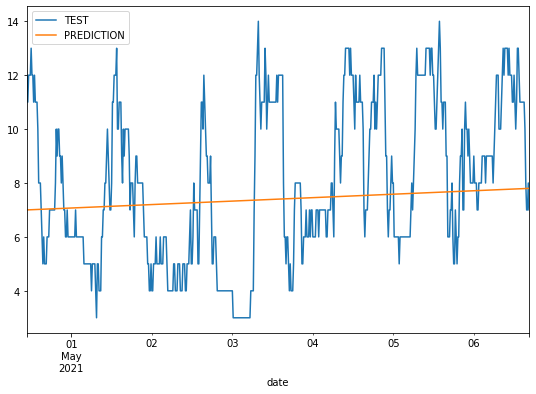

In [66]:
df_test['value'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,label='PREDICTION');
print(f'Mean Absolute Error = {mean_absolute_error(df_test["value"],test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(df_test["value"],test_predictions)}')